# Detecting patterns of speciation in the fos- sil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import geopandas as gpd
import statsmodels
import statsmodels.api as sm
import numpy as np
from scipy.stats import binom
from mpl_toolkits.axes_grid1 import make_axes_locatable

Exercise 1.
We saved the All NOW localities data as .txt file

Exercise 2.
Next we open the .txt file, create DataFrame and save it as a csv file (now_export_locsp_public_2023-05-13T10#54#08+0000.csv)

In [105]:

file_path = os.path.abspath('NOW_DATA.txt')
raw_df = pd.read_csv(file_path, sep=',')
raw_df.to_csv('NOW_DATA.csv', index=False)

#We check the number of rows in the DataFrame: 76328 rows
num_rows = raw_df.shape[0] 


Exercise 3. 
a
We filter out rows where LAT = LONG = 0 using boolean array
and filter out rows where SPECIES = 'sp' or 'indet'

b
We create age_mean column and place the occurrences into correct 
Mammal Neogene time units based on the age_mean. By using right=False boundary cases are placed on the older time unit. 
Value oldest gives the age of oldest fossil at 66.04 million years old.
We use max 67 min 23 range for pre-MN and for post-MN anything younger than 0.01.

We then drop the post-mn and pre-mn categories as we focus our analysis into mammal neogene time units
This step is not explicitly stated on the instructions, but we assume that is the intent
Oldest occurrences from that data are from the start of Cenozoic era with max_age of 66.04 million years
Relatively large number of first occurrences of species appear in the pre-mn category in Paleogene period
We study the emergence of species in the mammal neogene period

c
We check the localities Samos Main Bone Beds and Can Llobateres I
and see if all occurrences are in MN12 for Samos and MN9 for Can Llobateres I

d
We create new genus + species column and then use that column to create indentification numbers for each ocurrence

e
We check if localities contain duplicate species
From printout we can see that at least some localities do contain more than one occurrence of species
For example: Özluce has four different species and one of them has two occurences

f
We check the number of rows in the DataFrame again
We are down to 59473 rows from the original 76328


In [106]:

#Exercise 3. a)
raw_df = raw_df.loc[(raw_df['LAT'] !=0) & (raw_df['LONG'] !=0)]
raw_df = raw_df.loc[(raw_df['SPECIES'] !='sp') | (raw_df['SPECIES'] != 'indet')]
oldest = raw_df['MAX_AGE'].max() #66.04

#b)
raw_df['age_mean'] = (raw_df['MIN_AGE'] + raw_df['MAX_AGE']) /2
raw_df['MN_TIME'] = pd.cut(raw_df['age_mean'], bins=[0.0, 0.01, 0.85, 1.9, 2.5, 3.55, 5, 5.3, 7.1, 7.6, 8.9, 9.9, 11.2, 12.85, 14.2, 16.4, 17.2, 19.5, 21.7, 23, 67], 
labels=['post-MN', 'MQ19', 'MQ18', 'MN17', 'MN16', 'MN15', 'MN14', 'MN13', 'MN12', 'MN11', 'MN10', 'MN9', 'MN7-8', 'MN6', 'MN5', 'MN4', 'MN3', 'MN2', 'MN1', 'pre-MN'], right=False)

df = raw_df.drop(raw_df[(raw_df['MN_TIME'] == 'post-MN') | (raw_df['MN_TIME'] == 'pre-MN')].index)
df['MN_TIME'] = df['MN_TIME'].cat.remove_categories(['post-MN', 'pre-MN'])

mn_time_order = ['MN1', 'MN2', 'MN3', 'MN4', 'MN5', 'MN6', 'MN7-8', 'MN9', 'MN10', 'MN11', 'MN12', 'MN13', 'MN14', 'MN15', 'MN16', 'MN17', 'MQ18', 'MQ19']
df['MN_TIME'] = pd.Categorical(df['MN_TIME'], categories=mn_time_order, ordered=True)

#c)
bone_beds = df[df['NAME'] == "Samos Main Bone Beds"]

can_llo = df[df['NAME'] == "Can Llobateres 1"]
#We change all the mn_time values for Can Llobateres 1 locality into MN9
can_llo.loc[can_llo['MN_TIME'] == 'MN10', 'MN_TIME'] = 'MN9'

#d)
df['gen_spe'] = df['GENUS'] + '_' + df['SPECIES']
df['ID_NUMBER'] = pd.factorize(df['gen_spe'])[0]

#e)

species_in_localities = df.groupby('NAME')['ID_NUMBER'].value_counts()

df['duplicate_copies'] = df.groupby('NAME')['ID_NUMBER'].transform(lambda x: x.duplicated(keep='first'))
df = df[~df['duplicate_copies']]
df.drop('duplicate_copies', axis=1, inplace=True)
no_duplicate_species = df.groupby('NAME')['ID_NUMBER'].value_counts()

#f)

processed_rows = df.shape[0] 
species_count = df['ID_NUMBER'].nunique()
locality_count = df['NAME'].nunique()
#Number of species is 9102 and number of localities is 5785

Excercise 4
We create dataframe to show how many occurrences each species has in each Mammal Neogene time units
We also create dataframe that shows for each species the Mammal Neogene time unit where it was first observed

Then we calculate number of first occurrences in each time unit

We merge total occurrences and first occurrences on mn_time and
create proportion column for each time unit by dividing number of first occurrences 
in that time unit with total number of occurrences 59473

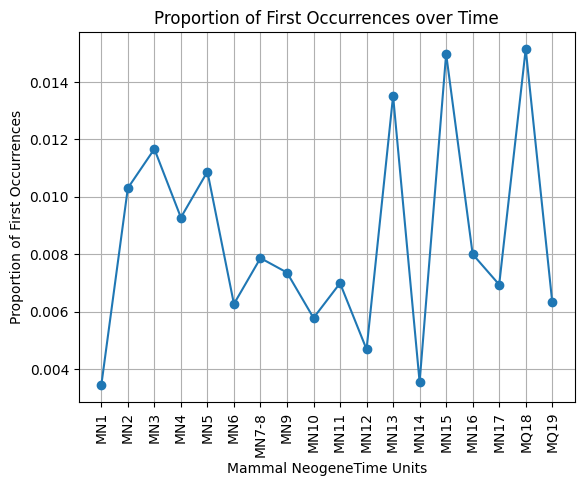

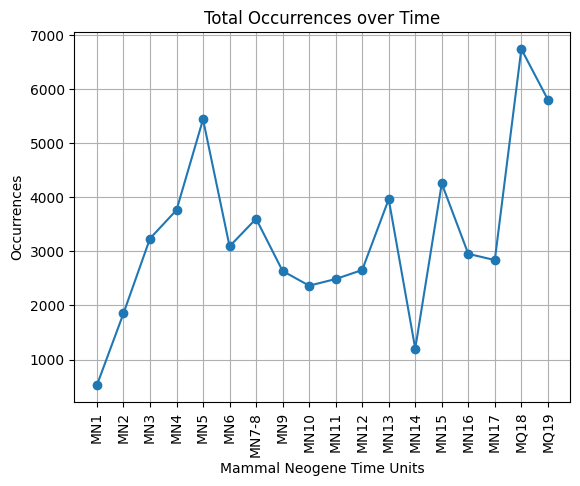

In [107]:

counts_df = df.groupby(['ID_NUMBER', 'MN_TIME']).size().reset_index(name='OCCURRENCES')
oldest_mn = df.groupby('ID_NUMBER')['MN_TIME'].idxmin()
oldest_mn_df = df.loc[oldest_mn, ['ID_NUMBER', 'MN_TIME']]

total_occurrences = counts_df.groupby('MN_TIME')['OCCURRENCES'].sum().reset_index()

first_occurrences = oldest_mn_df.groupby('MN_TIME')['ID_NUMBER'].nunique().reset_index()
first_occurrences.columns = ['MN_TIME', 'FIRST_OCCURRENCES']

proportions_df = pd.merge(total_occurrences, first_occurrences, on='MN_TIME', how='left')
proportions_df['PROPORTION'] = proportions_df['FIRST_OCCURRENCES'] / 59473

#We plot the proportion of first occurrences over time

proportions_df = proportions_df.sort_values('MN_TIME', ascending=False)
mn_prop_labels = proportions_df['MN_TIME'].values[::-1]
proportions = proportions_df['PROPORTION'].values[::-1]
plt.plot(range(len(proportions)), proportions, marker='o')
plt.xlabel('Mammal NeogeneTime Units')
plt.ylabel('Proportion of First Occurrences')
plt.title('Proportion of First Occurrences over Time')
plt.xticks(range(len(proportions)), mn_prop_labels, rotation=90)
plt.grid(True)
plt.show()

total_occurrences = total_occurrences.sort_values('MN_TIME', ascending=False)
mn_total_labels = total_occurrences['MN_TIME'].values[::-1]
total_occu = total_occurrences['OCCURRENCES'].values[::-1]
plt.plot(range(len(total_occu)), total_occu, marker='o')
plt.xlabel('Mammal Neogene Time Units')
plt.ylabel('Occurrences')
plt.title('Total Occurrences over Time')
plt.xticks(range(len(total_occu)), mn_total_labels, rotation=90)
plt.grid(True)
plt.show()


Excercise 5
We setup the worldmap using geopandas

a
We collect for each locality: locality number (LIDNUM), longitude(LONG), latitude(LAT), 
time unit(MN_TIME), number of first occurrences in the locality, number of all occurrences 
in the locality and proportion of first occurrences in the locality.
We Use LIDNUM to identify unique localities instead of NAME to make sure there are no duplicates
We create OCCURRENCES_LOCALITY and FIRST_OCCURRENCES_LOCALITY columns

b
We visualize the distribution of localities in space and time.

c
We look at the sampling density. Europe, southeast africa, india and southeast asia are high on mn13+ samples.
There are lot more early to mid mn time samples in north america. South america has less locales than other areas
but the number of occurrences seem to be higher.



C:\Users\Jani\AppData\Local\Temp\ipykernel_13728\4086228012.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\Jani\AppData\Local\Temp\ipykernel_13728\4086228012.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(smap, ticks=range(1, len(mn_time_unique) + 1))


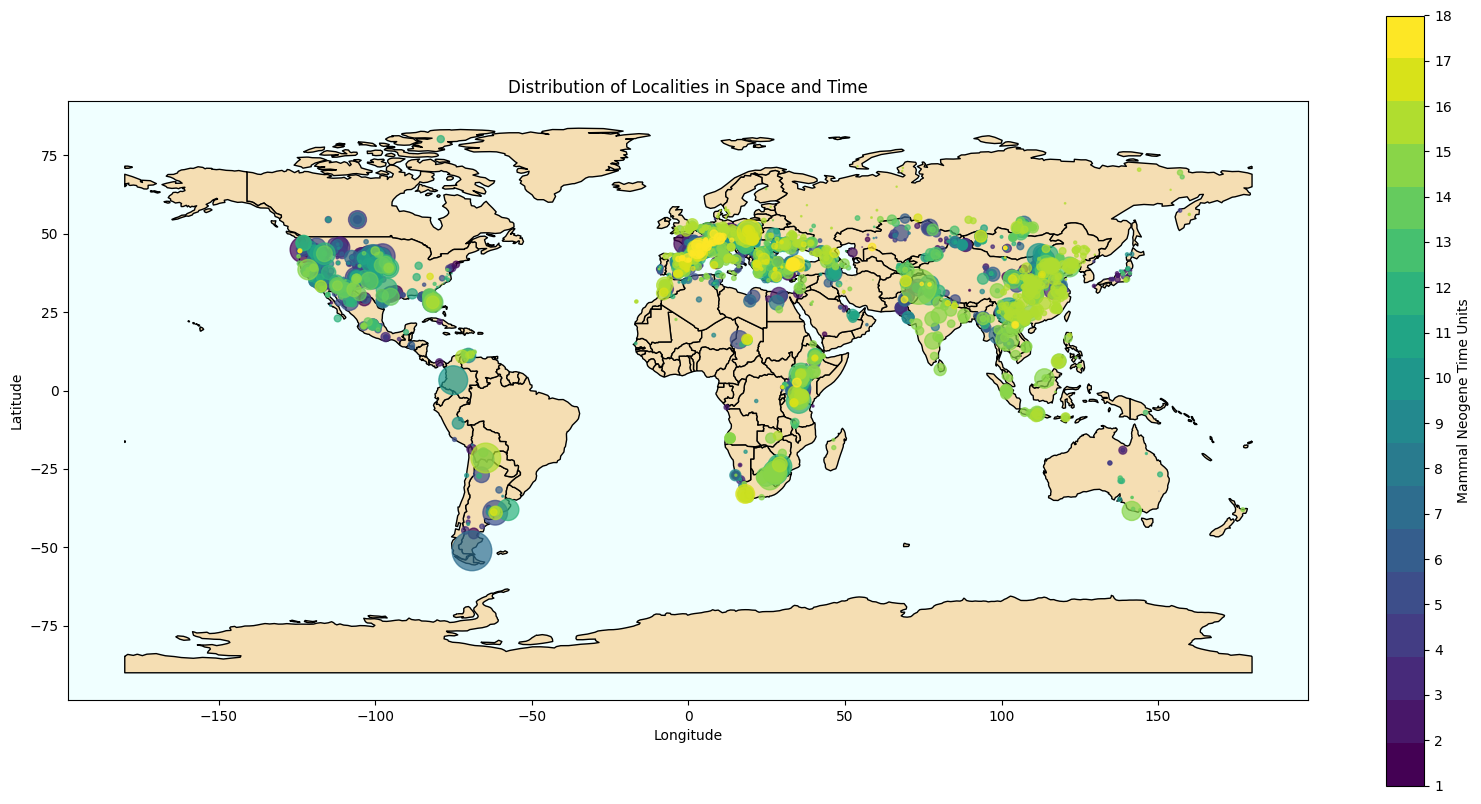

In [108]:


#a)
first_occurrences_locality = df.groupby('LIDNUM')['ID_NUMBER'].nunique().reset_index()
first_occurrences_locality.columns = ['LIDNUM', 'FIRST_OCCURRENCES_LOCALITY']

total_occurrences_locality = df.groupby('LIDNUM')['ID_NUMBER'].sum().reset_index(name='OCCURRENCES_LOCALITY')
locality_df = pd.merge(total_occurrences_locality, first_occurrences_locality, on='LIDNUM', how='left')

locality_df['PROPORTION'] = locality_df['FIRST_OCCURRENCES_LOCALITY'] / locality_df['OCCURRENCES_LOCALITY']
locality_df = pd.merge(locality_df, df[['LIDNUM', 'LONG', 'LAT', 'MN_TIME']].drop_duplicates(), on='LIDNUM', how='left')

#b)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 10))
world.plot(ax=ax, color='wheat', edgecolor='black')
ax.set_facecolor('azure')

mn_time_unique = locality_df['MN_TIME'].unique()
cmap = plt.get_cmap('viridis', len(mn_time_unique))
mn_time_color_mapping = {mn_time: color for mn_time, color in zip(mn_time_unique, cmap.colors)}

for time_unit in locality_df['MN_TIME'].unique():
    subset = locality_df[locality_df['MN_TIME'] == time_unit]
    sizes = subset['OCCURRENCES_LOCALITY'] * 0.001
    ax.scatter(subset['LONG'], subset['LAT'], s=sizes, color=mn_time_color_mapping[time_unit], label=time_unit, alpha=0.7)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Distribution of Localities in Space and Time')

norm = mcolors.Normalize(vmin=1, vmax=len(mn_time_unique))
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
smap.set_array([]) 
cbar = plt.colorbar(smap, ticks=range(1, len(mn_time_unique) + 1))
cbar.set_label('Mammal Neogene Time Units')
plt.show()


Excercise 6
We create focal locality columns into locality_df dataframe

In [109]:

#6)
def calculate_area_data(row):
    lat = row['LAT']
    lon = row['LONG']
    mn_time = row['MN_TIME']
    
    lat_upper = lat + 5
    lat_lower = lat - 5
    lon_left = lon - 5
    lon_right = lon + 5
    
    occurrences_area = df[
        (df['LAT'] >= lat_lower) & (df['LAT'] <= lat_upper) &
        (df['LONG'] >= lon_left) & (df['LONG'] <= lon_right) &
        (df['MN_TIME'] == mn_time)]

    total_occurrences_area = occurrences_area.shape[0]
    first_occurrences_area = occurrences_area['ID_NUMBER'].nunique()
    
    row_index = locality_df[locality_df['LIDNUM'] == row['LIDNUM']].index[0]
    preceding_mn_time_index = row_index - 1
    
    if preceding_mn_time_index >= 0:
        preceding_mn_time = locality_df.loc[preceding_mn_time_index, 'MN_TIME']
        occurrences_preceding_area = df[
            (df['LAT'] >= lat_lower) & (df['LAT'] <= lat_upper) &
            (df['LONG'] >= lon_left) & (df['LONG'] <= lon_right) &
            (df['MN_TIME'] == preceding_mn_time)
        ]
        total_occurrences_preceding_area = occurrences_preceding_area.shape[0]
    else:
        total_occurrences_preceding_area = 0
    
    locality_df.at[row_index, 'OCCURRENCES_AREA'] = total_occurrences_area
    locality_df.at[row_index, 'FIRST_OCCURRENCES_AREA'] = first_occurrences_area
    locality_df.at[row_index, 'OCCURRENCES_PRECEDING_AREA'] = total_occurrences_preceding_area

locality_df.apply(calculate_area_data, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
5781    None
5782    None
5783    None
5784    None
5785    None
Length: 5786, dtype: object

Excercise 7
We set up logistic regression

a
We limit our area to Europe and time frame to MN2-MQ19. We cannot include 
MN1 as we can't get data from previous time period. 

b
We create summary for the regression

c
We plot the regression curve and 95%-confidence intervals


Optimization terminated successfully.
         Current function value: 0.532407
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3144
Model:                          Logit   Df Residuals:                     3142
Method:                           MLE   Df Model:                            1
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:                 0.01265
Time:                        21:33:50   Log-Likelihood:                -1673.9
converged:                       True   LL-Null:                       -1695.3
Covariance Type:            nonrobust   LLR p-value:                 5.740e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8867      0.064    -13.822      0.000      -1.012      -0.761
x1            -0.0007      0.

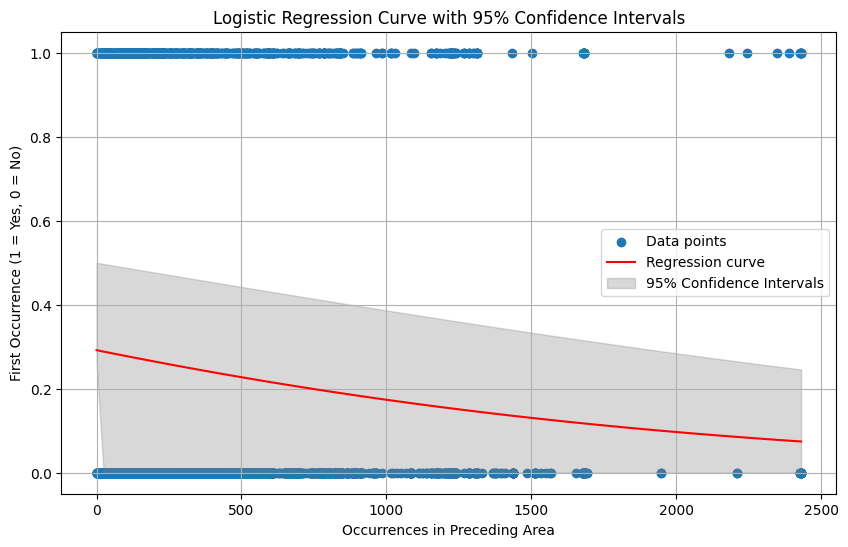

In [110]:


#a)
regression = []

for index, row in locality_df.iterrows():
    if row['LONG'] > -25 and row['LONG'] < 40 and row['LAT'] > 35 and row['MN_TIME'] != 'MN1':
        focal_area_occurrences = row['OCCURRENCES_PRECEDING_AREA']
        is_first_occurrence = 1 if row['FIRST_OCCURRENCES_LOCALITY'] == 1 else 0
        regression.append([focal_area_occurrences, is_first_occurrence])

regression = np.array(regression)
X = regression[:, :-1]
X = np.column_stack((np.ones(X.shape[0]), X))

y = regression[:, -1]  

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())
coefficients = result.params
confidence_95 = result.conf_int(alpha=0.05)

#c)
coefficients = result.params
x_values = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)  
y_values = np.exp(coefficients[0] + coefficients[1] * x_values) / (1 + np.exp(coefficients[0] + coefficients[1] * x_values))

confidence_intervals = np.exp(confidence_95[0][0] + confidence_95[0][1] * x_values) / (1 + np.exp(confidence_95[0][0] + confidence_95[0][1] * x_values)), \
                       np.exp(confidence_95[1][0] + confidence_95[1][1] * x_values) / (1 + np.exp(confidence_95[1][0] + confidence_95[1][1] * x_values))

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 1], y, marker='o', label='Data points')
plt.plot(x_values, y_values, color='red', label='Regression curve')
plt.fill_between(x_values, confidence_intervals[0], confidence_intervals[1], color='gray', alpha=0.3, label='95% Confidence Intervals')
plt.xlabel('Occurrences in Preceding Area')
plt.ylabel('First Occurrence (1 = Yes, 0 = No)')
plt.title('Logistic Regression Curve with 95% Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()


Excercise 8
We calculate the expected probabilities of first occurrences in focal area
using the logistic regression model for European localities.


In [111]:


expected_probs = result.predict(locality_df[['OCCURRENCES_PRECEDING_AREA', 'FIRST_OCCURRENCES_AREA']])
locality_df['EXPECTED_PROB'] = expected_probs
locality_df['EXPECTED_PROP_FIRST'] = locality_df['EXPECTED_PROB'] * locality_df['FIRST_OCCURRENCES_AREA']
#print(expected_probs)


C:\Users\Jani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Excercise 9
We calculate the probability of observing as many or more first occurrences in the focal
area than what is actually found. We use scipy.stats.binom and assume the occurrences
are bonomially distributed. We add the probabilities as a new column 


In [112]:

expected_probs_of_first = locality_df['EXPECTED_PROB']
observed_first_occurrences = locality_df['FIRST_OCCURRENCES_AREA']

greater_or_equal = 1 - binom.cdf(observed_first_occurrences - 1, n=len(locality_df), p=expected_probs)
locality_df['GREATER_OR_EQUAL'] = greater_or_equal



Excercise 10
We highlight on map the localities that have p-value less than 0.05. 
All the occurrences seem to have quite low probability of observation,
with one exception of occurrence in Tunisia.

C:\Users\Jani\AppData\Local\Temp\ipykernel_13728\460612077.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


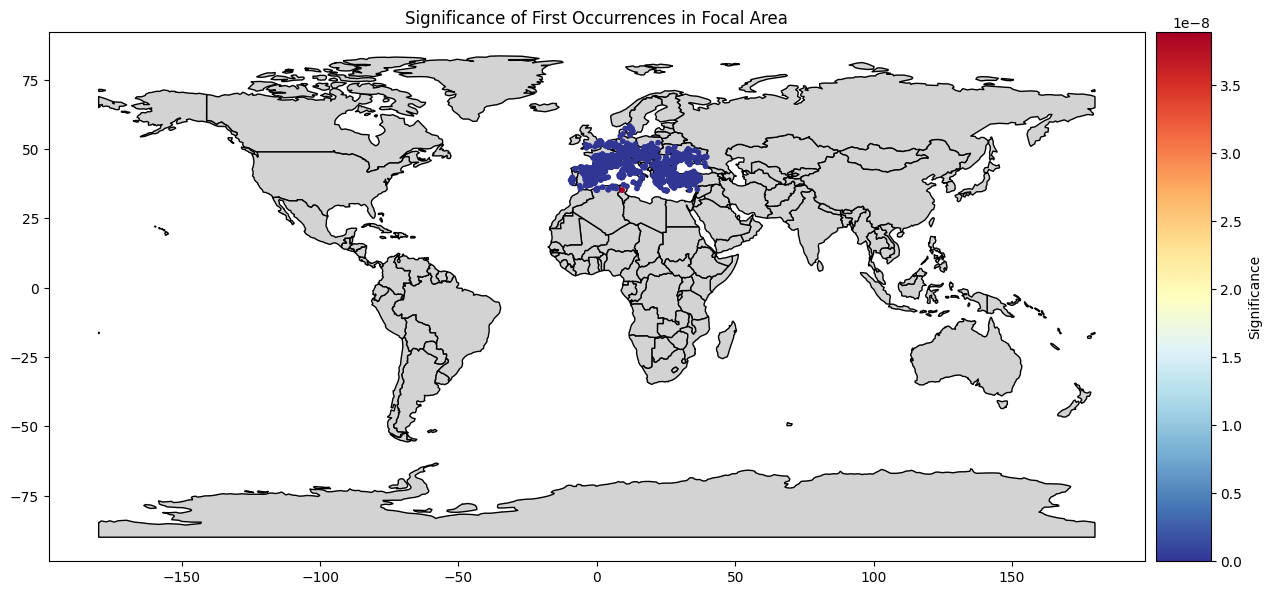

In [113]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

filtered_localities = locality_df[
    (locality_df['LONG'] > -25) & 
    (locality_df['LONG'] < 40) & 
    (locality_df['LAT'] > 35)
]

significant_localities = filtered_localities[filtered_localities['GREATER_OR_EQUAL'] <= 0.05]

fig, ax = plt.subplots(figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax, color='lightgrey', edgecolor='black')

sc = ax.scatter(
    significant_localities['LONG'], 
    significant_localities['LAT'], 
    c=significant_localities['GREATER_OR_EQUAL'], 
    cmap='RdYlBu_r', 
    s=10
)
ax.set_title('Significance of First Occurrences in Focal Area')
plt.colorbar(sc, cax=cax, label='Significance Level')
plt.ylabel('Significance')
plt.show()